
# Istanbul Real Estate Price Predictions

Exploring an online Real Estate ad website's Dataset containing 117.624 properties for the year 2017. 


Predicting sale prices using Linear Regression and LightGBM models.



## Loading Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None 
import seaborn as sns
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)

## Reading and Cleaning the Data

In [2]:
df = pd.read_excel("real-estate-data.xlsx")
print("Row and Feature Counts",df.shape)
df.columns

Row and Feature Counts (117624, 23)


Index(['No', 'CreatedDate', 'Photo', 'CityID', 'CityName', 'TownID',
       'TownName', 'DistrictID', 'DistrictName', 'Lon', 'Lat',
       'CalculatedStartingPrice', 'LabelDesc', 'SubCategoryName', 'RoomCount',
       'Banyo Sayısı', 'Site İçerisinde', 'Bina Yaşı', 'Binadaki Kat Sayısı',
       'Bulunduğu Kat', 'Isıtma', 'Eşyalı', 'M2AdvertPropertyValue'],
      dtype='object')

In [3]:
df.columns = ["No", "Ad_Date", "Photo_Link", "City_Code", "City_Name", "District_Code", "District_Name", "Neighbourhood_Code",
              "Neighbourhood_Name", "Longitude", "Lattitude", "Price", "Ad_Type", "Property_Type", "Living_Room_Room_Count", "Bathroom_Count",
              "Building_Complex", "Building_Age", "Building_Floor_Count", "Property_Floor", "Heating_Type", "Furniture", "Square_Meter"]

We can drop "No" and "Foto_Linki" columns since we won't use it on our predictions.

In [4]:
Drop_Columns =["No","Photo_Link"]
df.drop(Drop_Columns, axis=1, inplace=True)

Converting Mahalle_ismi to str (19 Mayıs may be taken as a datetime)

In [5]:
df["Neighbourhood_Name"]=df["Neighbourhood_Name"].astype(str)

In [6]:
df.head()

,Ad_Date,City_Code,City_Name,District_Code,District_Name,Neighbourhood_Code,Neighbourhood_Name,Longitude,Lattitude,Price,...,Property_Type,Living_Room_Room_Count,Bathroom_Count,Building_Complex,Building_Age,Building_Floor_Count,Property_Floor,Heating_Type,Furniture,Square_Meter
0,2017-12-20,1,İstanbul Avrupa,1746,Başakşehir,7816,Kayabaşı,28.750233,41.119747,155000.0,...,Daire,2 + 1,1,Evet,3 - 4 yıl,8,8,Merkezi Sistem (Isı Pay Ölçer),Hayır,68.0
1,2017-06-14,1,İstanbul Avrupa,21,Sarıyer,1601,Maden,29.037741,41.174553,466000.0,...,Daire,2 + 1,1,NaN,0,3,1,Kombi (Doğalgaz),NaN,95.0
2,2017-06-14,1,İstanbul Avrupa,21,Sarıyer,1601,Maden,29.037741,41.174553,466000.0,...,Daire,2 + 1,1,NaN,0,3,1,Kombi (Doğalgaz),NaN,95.0
3,2017-12-01,1,İstanbul Avrupa,24,Şişli,1634,İnönü,NaN,NaN,2650.0,...,Daire,2 + 1,1,NaN,21 - 25 yıl,3,3,Kombi (Doğalgaz),NaN,75.0
4,2017-01-01,189,İstanbul Anadolu,1751,Sancaktepe,5702,Fatih,29.220865,40.964668,350000.0,...,Daire,1 + 1,1,Evet,0,10 üzeri,6,Merkezi Sistem (Isı Pay Ölçer),Hayır,78.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117624 entries, 0 to 117623
Data columns (total 21 columns):
Ad_Date                   117624 non-null datetime64[ns]
City_Code                 117624 non-null int64
City_Name                 117624 non-null object
District_Code             117624 non-null int64
District_Name             117624 non-null object
Neighbourhood_Code        117624 non-null int64
Neighbourhood_Name        117624 non-null object
Longitude                 102073 non-null float64
Lattitude                 102071 non-null float64
Price                     117624 non-null float64
Ad_Type                   117624 non-null object
Property_Type             117624 non-null object
Living_Room_Room_Count    116468 non-null object
Bathroom_Count            108635 non-null object
Building_Complex          105007 non-null object
Building_Age              116103 non-null object
Building_Floor_Count      112961 non-null object
Property_Floor            114231 non-null object

Let's take first look to our data using ProfileReport

# EDA

## Missing Values

Let's see each column's missing value rates.

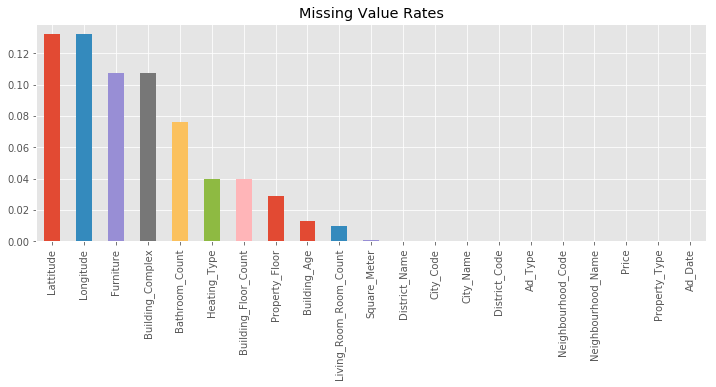

In [8]:

plt.figure(figsize=(12,4))
((df.isnull().sum()/df.shape[0]).sort_values(ascending=False)).plot(kind="bar", title="Missing Value Rates");

We have missing values on 9 features (0.008 to 0.132)

## Outliers

We have 2 Continous variable (Price and Square Metter)

### Price

Changing Advert Type names to English

In [9]:
df["Ad_Type"].replace({"Kiralık": "For_Rent", "Satılık": "For_Sale"},inplace=True)

#### Rent Prices

In [10]:
pd.options.display.float_format = '{:20,.2f}'.format #This is to disable scientifique notation
df[df["Ad_Type"]=="For_Rent"]["Price"].describe()

count              41,087.00
mean               42,828.04
std             5,728,745.69
min                     0.00
25%                 1,100.00
50%                 1,500.00
75%                 2,300.00
max         1,000,100,000.00
Name: Price, dtype: float64

It seems there are some extreme values on rent prices (std is quite high). Max price is 1 billion TL (~178 Million USD) which is clearly a wrong entry, checking for other outliers.

In [11]:
df[df["Ad_Type"]=="For_Rent"][["Price","Living_Room_Room_Count","Square_Meter"]].sort_values(by="Price",ascending=False).head(10)

,Price,Living_Room_Room_Count,Square_Meter
112590,"1,000,100,000.00",4 + 1,75.00
111748,"590,000,000.00",2 + 1,110.00
106367,"6,000,000.00",NaN,960.00
102597,"5,000,000.00",2 + 1,50.00
102718,"5,000,000.00",2 + 1,50.00
103385,"4,250,000.00",4 + 1,250.00
19608,"2,550,000.00",4 + 2,190.00
112021,"2,500,000.00",3 + 1,130.00
93943,"2,500,000.00",2 + 1,130.00
88627,"2,400,000.00",4 + 2,210.00


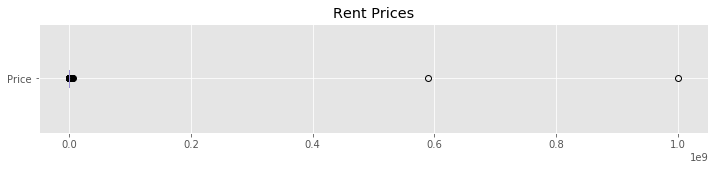

In [12]:
# Boxplot
df[df["Ad_Type"]=="For_Rent"]["Price"].plot(kind="box",vert=False,figsize=(12,2),title="Rent Prices");

#### Sale Prices

In [13]:
df[df["Ad_Type"]=="For_Sale"][["Price"]].sort_values(by="Price").describe()

,Price
count,"76,532.00"
mean,"921,350.65"
std,"20,988,883.55"
min,0.00
25%,"225,000.00"
50%,"325,000.00"
75%,"520,000.00"
max,"5,009,999,994.99"


There are some extreme values on sale prices (std is quite high). Max price is 5 billion TL (~900 Million USD) which is clearly a wrong entry, checking for other outliers. Also sale 0 TL sale prices are present.

In [14]:
df[df["Ad_Type"]=="For_Sale"][["Price","Living_Room_Room_Count","Square_Meter"]].sort_values(by="Price",ascending=False).head(10)

,Price,Living_Room_Room_Count,Square_Meter
23777,"5,009,999,994.99",1 + 1,"14,900.00"
1029,"2,003,400,000.00",NaN,"200,000.00"
897,"740,880,000.00",NaN,"50,000.00"
20160,"605,000,000.00",7 + 2,"16,000.00"
105356,"500,000,000.00",3 + 1,120.00
45277,"500,000,000.00",NaN,100.00
45276,"500,000,000.00",NaN,100.00
55878,"500,000,000.00",NaN,120.00
27270,"475,000,000.00",4 + 1,175.00
107698,"446,040,000.00",Stüdyo,"58,000.00"


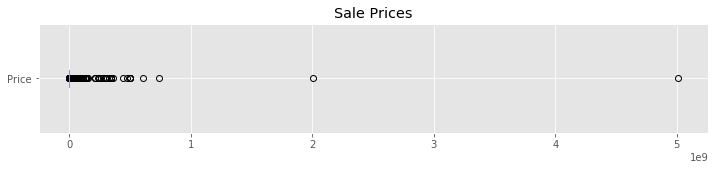

In [15]:
# Boxplot
df[df["Ad_Type"]=="For_Sale"][["Price"]].plot(kind="box",vert=False,figsize=(12,2),title="Sale Prices");

Most of the top 10 prices are seems to be wrong entires

### Square Meters

In [16]:
df["Square_Meter"].describe()

count             117,527.00
mean                  430.22
std                75,499.55
min                     0.00
25%                    85.00
50%                   110.00
75%                   140.00
max            25,659,845.00
Name: Square_Meter, dtype: float64

In [17]:
df[["Price","Living_Room_Room_Count","Square_Meter"]].sort_values(by="Square_Meter",ascending=False).head(10)

,Price,Living_Room_Room_Count,Square_Meter
93963,"1,111,111.00",2 + 1,"25,659,845.00"
16675,"27,000,000.00",1 + 1,"3,166,667.00"
12008,"615,000.00",3 + 1,"575,000.00"
73654,"735,000.00",3 + 2,"535,000.00"
26260,"320,000.00",2 + 1,"320,000.00"
105000,"275,000.00",2 + 1,"275,000.00"
113193,"50,000.00",1 + 1,"273,773.00"
6226,"249,000.00",2 + 1,"249,000.00"
108198,"729,000.00",1 + 1,"240,000.00"
46615,"550,000.00",4 + 2,"220,000.00"


Same as Prices we have some wrong entries as outliers on Square_Meter feature.

## Features

### Type of Adverts

In [18]:
df["Ad_Type"].value_counts(sort=True, ascending=True)

Arıyorum        5
For_Rent    41087
For_Sale    76532
Name: Ad_Type, dtype: int64

Dropping "Arıyorum (Searcing for)" advert type

In [19]:
df=df.loc[~(df["Ad_Type"]=="Arıyorum")]

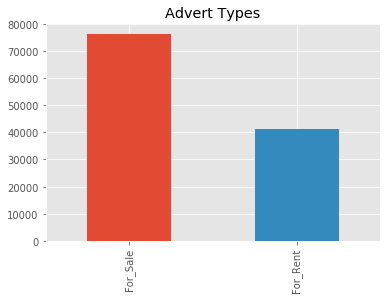

In [20]:

df["Ad_Type"].value_counts(sort=True, ascending=False).plot(kind="bar", title="Advert Types");

### Price (Target Variable)

#### For Rent Prices

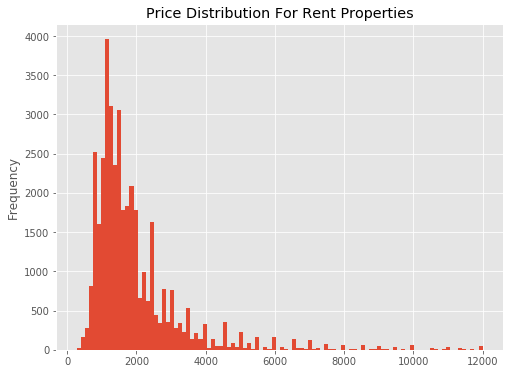

In [21]:
plt.figure(figsize=(8,6))
df[df["Ad_Type"]=="For_Rent"]["Price"]\
.plot(title="Price Distribution For Rent Properties",kind="hist",bins=100
      #putting range to histogram to prevent outliers to ruin the histogram
      ,range=[np.percentile(df[df["Ad_Type"]=="For_Rent"]["Price"].values, 2.5), np.percentile(df[df["Ad_Type"]=="For_Rent"]["Price"].values, 97.5)]);
 

We have right skewed normal distribution for Rent prices

#### For Sale Prices

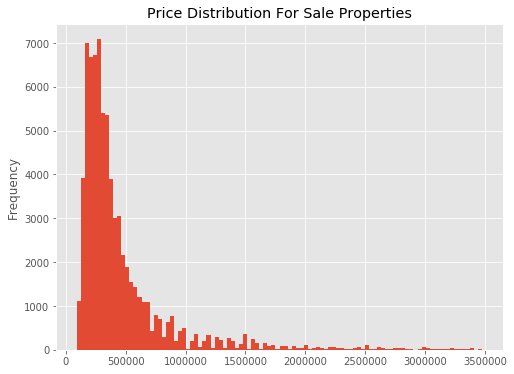

In [22]:
plt.figure(figsize=(8,6))
df[df["Ad_Type"]=="For_Sale"]["Price"]\
.plot(title="Price Distribution For Sale Properties",kind="hist",bins=100
      #putting range to histogram to prevent outliers to ruin the histogram
      ,range=[np.percentile(df[df["Ad_Type"]=="For_Sale"]["Price"].values, 1), np.percentile(df[df["Ad_Type"]=="For_Sale"]["Price"].values, 97.5)]);
 

### Advert Dates

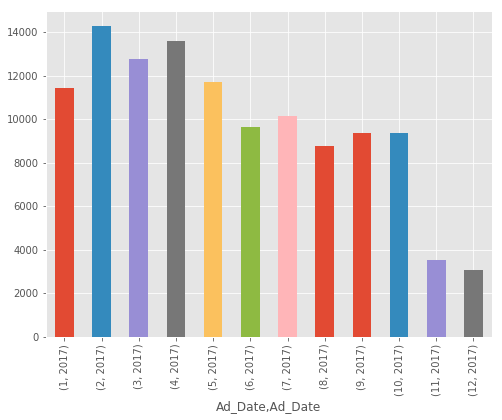

In [23]:
plt.figure(figsize=(8,6))
df.groupby([df["Ad_Date"].dt.month,df["Ad_Date"].dt.year]).size().plot(kind="bar");

We have 1 year data of 2017.Fewer data point at the end of the year.

### Cities
Let's now see the cities in dataset

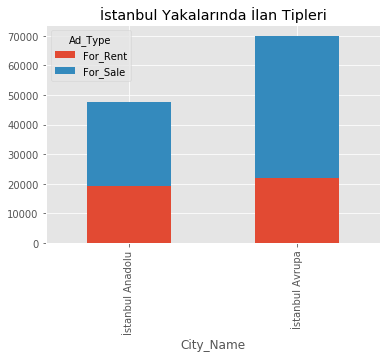

In [24]:
df.groupby(by=["Ad_Type", "City_Name"]).size().unstack("Ad_Type").plot(kind="bar"
                                    ,stacked=True,title="İstanbul Yakalarında İlan Tipleri");

We have only Istanbul as city, separated on 2 parts; Anadolu (Anatolain) and Avrupa (Europe).Most of the adverts are "For_Sale".

Let's now check districts

## Districts

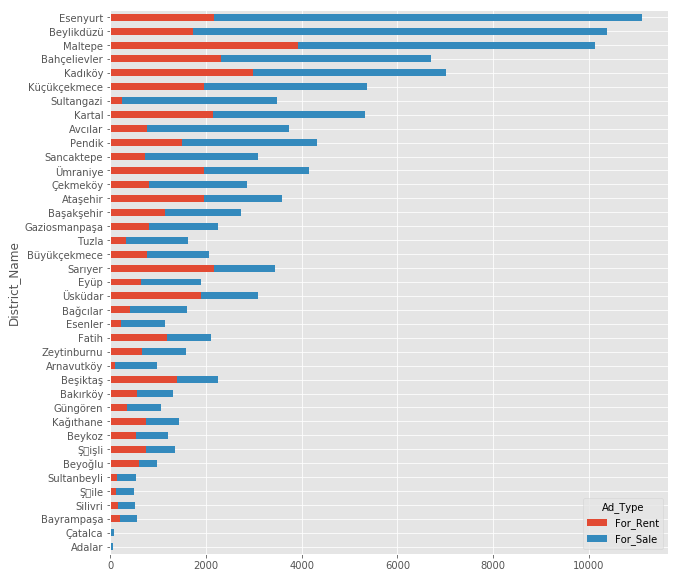

In [25]:
(df.groupby(["District_Name","Ad_Type"]).size().unstack("Ad_Type").sort_values("For_Sale",ascending=True))\
.plot(kind="barh",stacked=True,figsize=(10,10));

## Type of Property:

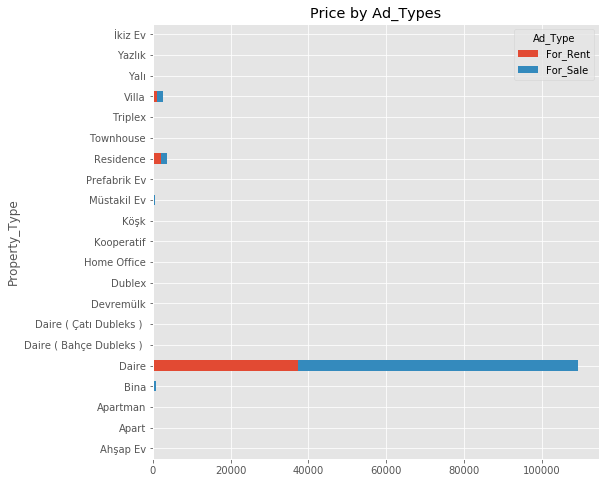

In [26]:
df.groupby(by=["Ad_Type", "Property_Type"]).size().unstack("Ad_Type").plot(kind="barh", stacked=True,figsize=(8,8),
                                                      title="Price by Ad_Types");

Most of the properties are apartments (Daire).

### Rooms and living rooms

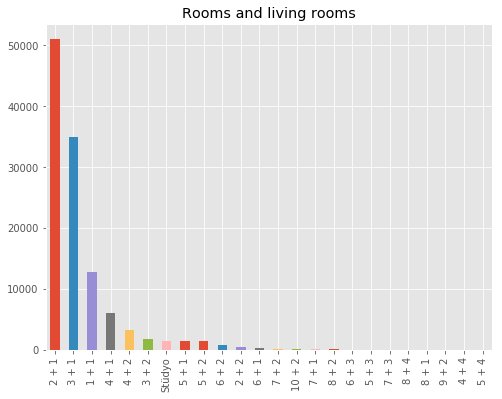

In [27]:
plt.figure(figsize=(8,6))
df.Living_Room_Room_Count.value_counts(sort=True, ascending=False)\
.plot(kind="bar",title="Rooms and living rooms");

Most of them have 2-3 rooms and 1 living room.

### Age of Buildings

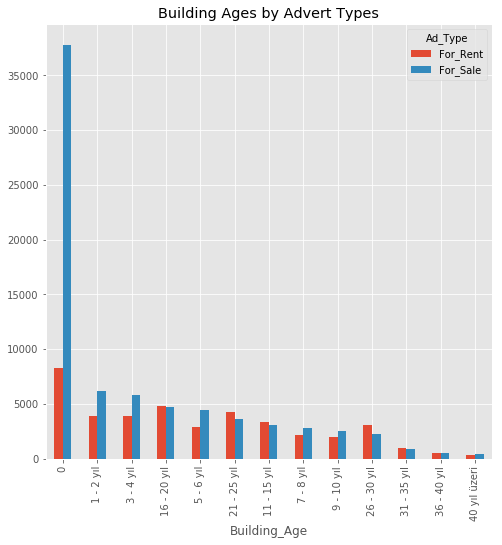

In [28]:
df.groupby(by=["Building_Age","Ad_Type"]).size().unstack("Ad_Type").sort_values("For_Sale",ascending=False)\
.plot(kind="bar",figsize=(8,8),title="Building Ages by Advert Types");

Most of the buildings are new (0-4 years old), Rate of the For_rent properties is higher with old buildings in Istanbul

Let's check numbers of rooms on new properties and see if new buildings have less or more rooms.

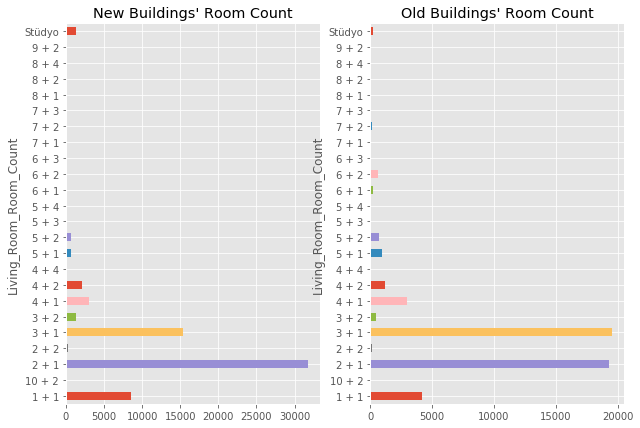

In [29]:
New_Estates = df[(df["Building_Age"]==0)|(df["Building_Age"]=='1 - 2 yıl')|(df["Building_Age"]=='3 - 4 yıl')]
New_Estates_Room=New_Estates.groupby(by=["Living_Room_Room_Count"]).size()
Old_Estates=df[~df.index.isin(New_Estates.index)]
Old_Estates_Room=Old_Estates.groupby(by=["Living_Room_Room_Count"]).size()

fig = plt.figure(figsize=(10,7))

plt.subplot(1, 2, 1)
New_Estates_Room.plot(kind="barh",title="New Buildings' Room Count");

plt.subplot(1, 2, 2)
Old_Estates_Room.plot(kind="barh",title="Old Buildings' Room Count");


3 rooms' rate is higher in old buildings. Let's see where new buildings are constructed most.  

<Figure size 864x864 with 0 Axes>

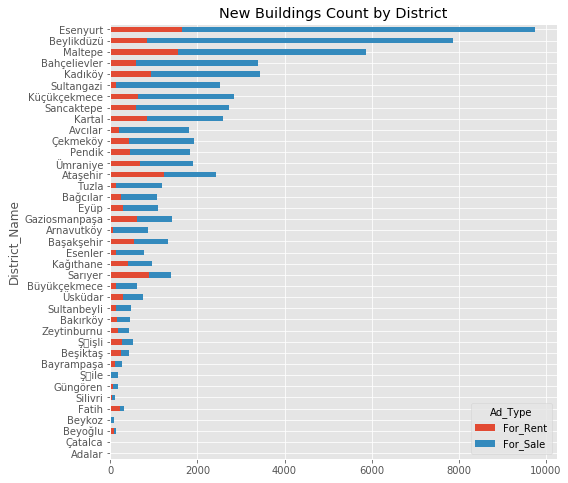

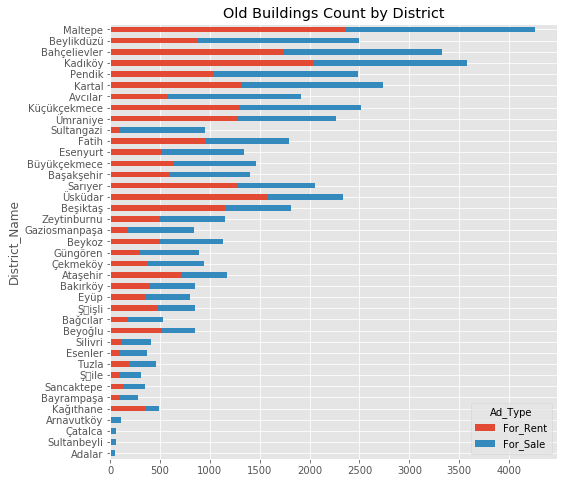

In [30]:
fig = plt.figure(figsize=(12,12));



New_Estates.groupby(by=["District_Name","Ad_Type"]).size().unstack("Ad_Type")\
.sort_values("For_Sale",ascending=True)\
.plot(kind="barh", stacked=True, title="New Buildings Count by District",figsize=(8,8));



Old_Estates.groupby(by=["District_Name","Ad_Type"]).size().unstack("Ad_Type")\
.sort_values("For_Sale",ascending=True)\
.plot(kind="barh", stacked=True, title="Old Buildings Count by District",figsize=(8,8));


### Bathroom Count

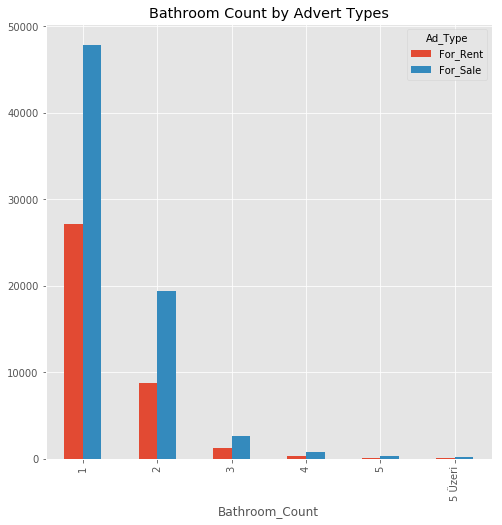

In [31]:
df.groupby(by=["Bathroom_Count","Ad_Type"]).size().unstack("Ad_Type").sort_values("For_Sale",ascending=False)\
.plot(kind="bar",figsize=(8,8),title="Bathroom Count by Advert Types");

### Building Complex

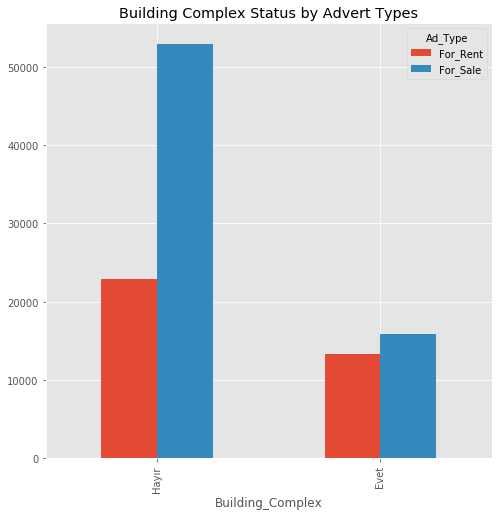

In [32]:
df.groupby(by=["Building_Complex","Ad_Type"]).size().unstack("Ad_Type").sort_values("For_Sale",ascending=False)\
.plot(kind="bar",figsize=(8,8),title="Building Complex Status by Advert Types");

Building Complex Rate is higher on For Rent adverts 

### Building Floor Count

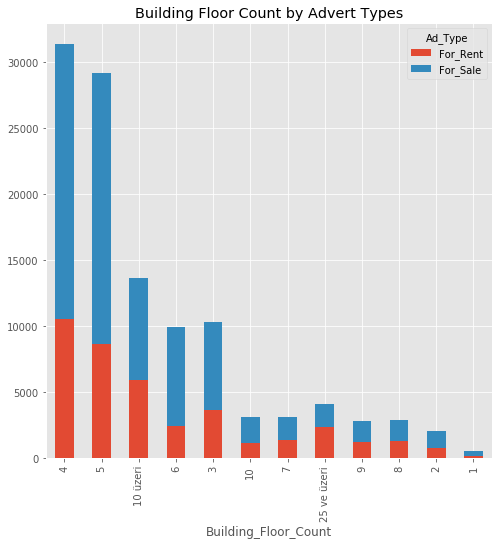

In [33]:
df.groupby(by=["Building_Floor_Count","Ad_Type"]).size().unstack("Ad_Type").sort_values("For_Sale",ascending=False)\
.plot(kind="bar",figsize=(8,8),title="Building Floor Count by Advert Types",stacked=True);

Most of the buildings have  less than 6 floors. Let's compare new constructed and old buildings

<Figure size 864x864 with 0 Axes>

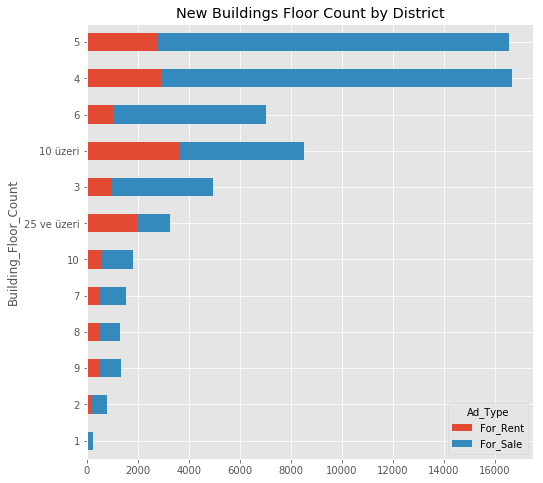

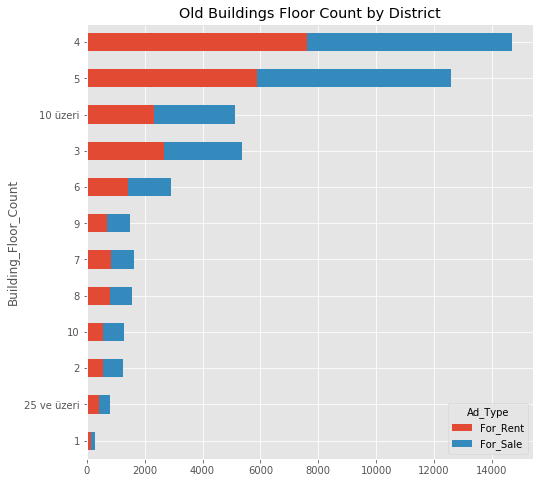

In [34]:
fig = plt.figure(figsize=(12,12));



New_Estates.groupby(by=["Building_Floor_Count","Ad_Type"]).size().unstack("Ad_Type")\
.sort_values("For_Sale",ascending=True)\
.plot(kind="barh", stacked=True, title="New Buildings Floor Count by District",figsize=(8,8));



Old_Estates.groupby(by=["Building_Floor_Count","Ad_Type"]).size().unstack("Ad_Type")\
.sort_values("For_Sale",ascending=True)\
.plot(kind="barh", stacked=True, title="Old Buildings Floor Count by District",figsize=(8,8));


No big difference with floor counts on new and old buildings. +25 floors rate is higher with new buildings.

### Square Meters

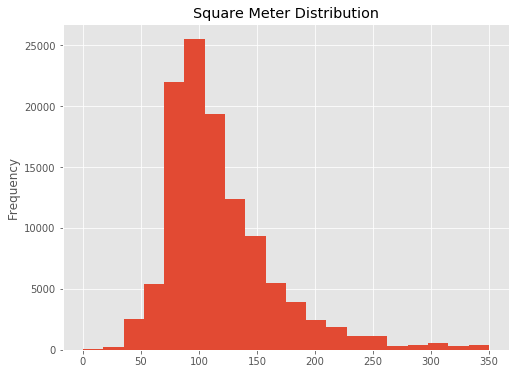

In [35]:
plt.figure(figsize=(8,6))
df["Square_Meter"].plot(title="Square Meter Distribution",kind="hist",bins=20
      #putting range to histogram to prevent outliers to ruin the histogram
      ,range=[np.percentile(df["Square_Meter"].dropna().values, 0), np.percentile(df["Square_Meter"].dropna().values, 97.5)]);
 

Let's check if propreties in new constructed buildings are larger or not.

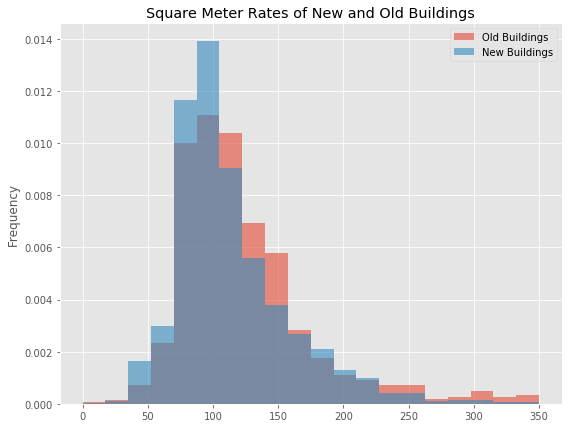

In [36]:
fig = plt.figure(figsize=(9,7));

Old_Estates["Square_Meter"].dropna().plot(kind="hist" ,density=1,range=[np.percentile(df["Square_Meter"].dropna().values, 0), np.percentile(df["Square_Meter"].dropna().values, 97.5)],\
        bins=20,alpha=0.6);

New_Estates["Square_Meter"].dropna().plot(kind="hist",density=1 ,range=[np.percentile(df["Square_Meter"].dropna().values, 0), np.percentile(df["Square_Meter"].dropna().values, 97.5)],\
        bins=20,alpha=0.6,title="Square Meter Rates of New and Old Buildings");
plt.legend(labels= ["Old Buildings","New Buildings"]);


Properties in old buildings tend to be larger in general.

### Property Floor

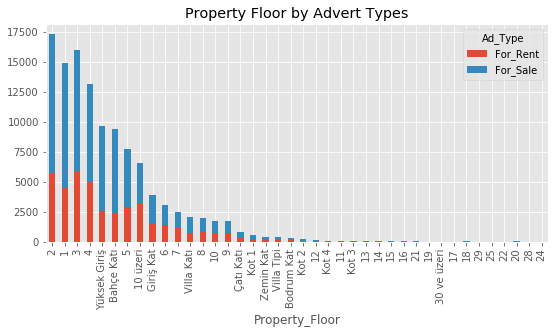

In [37]:
df.groupby(by=["Property_Floor","Ad_Type"]).size().unstack("Ad_Type").sort_values("For_Sale",ascending=False)\
.plot(kind="bar",figsize=(9,4),title="Property Floor by Advert Types",stacked=True);

### Heating Type

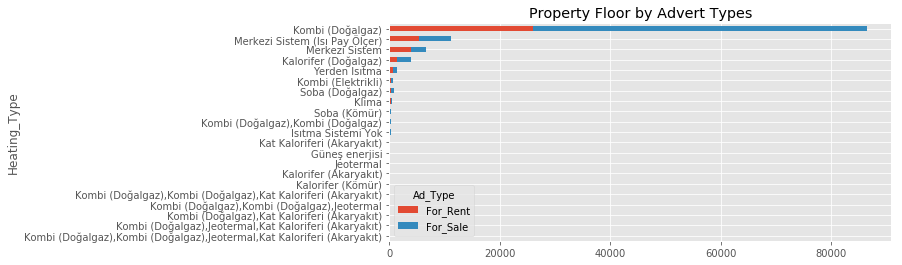

In [38]:
df.groupby(by=["Heating_Type","Ad_Type"]).size().unstack("Ad_Type").sort_values("For_Sale",ascending=True)\
.plot(kind="barh",figsize=(9,4),title="Property Floor by Advert Types",stacked=True);

### Furniture

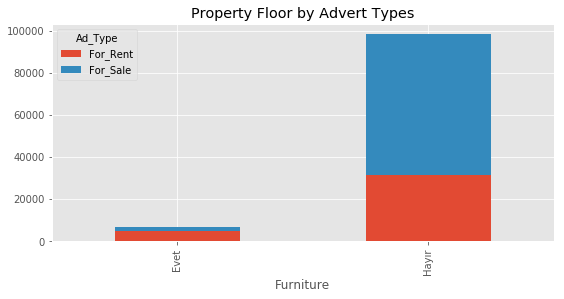

In [39]:
df.groupby(by=["Furniture","Ad_Type"]).size().unstack("Ad_Type").sort_values("For_Sale",ascending=True)\
.plot(kind="bar",figsize=(9,4),title="Property Floor by Advert Types",stacked=True);

Most of the propreties are without furniture.

# Feature Engineering

We will use only sale adverts of appartments to make predictions

In [40]:
dfs=df[(df["Ad_Type"]=="For_Sale") & (df["Property_Type"]=="Daire")]

In [41]:
shape_before=dfs.shape

* Checking Outliers
* Convert string values to numeric. Also There are columns with 2 separate values (Room_Living_Room_Count), we will split them to multiple columns with single value ("Room_Count" and "Living_Room_Count")
* Checking for bad data (like 60 square metter appartment with 10 room) and erase them, we could just let algorithms handle those but it will weaken some models like Linear Regression.
* Adding some new variables
* Checking features and target variable (Price) relations.

### Outliers

As we saw on EDA section we have some outliers on prices and square meters, most of them are probably wrong entires.

#### Prices

Some of sale prices are over 5 billion TL. Those outliers would effect our model's prediction results badly. We will remove %0.3 from to top and %1 from the buttom (to eliminate 0 values).


In [42]:
upper_limit = np.percentile(dfs["Price"].values, 99.7)
buttom_limit = np.percentile(dfs["Price"].values, 1)
dfs= dfs.loc[ (dfs["Price"]<=upper_limit)&(dfs["Price"]>=buttom_limit)]

dfs["Price"].describe()

count              71,073.00
mean              471,260.20
std               592,442.23
min                94,000.00
25%               225,000.00
50%               315,000.00
75%               480,000.00
max             6,993,000.00
Name: Price, dtype: float64

Price seems reasonable after cutting.

#### Square Meters

Let's do the same for square meter. Let's do it with quantile method this time.

In [43]:
dfs["Square_Meter"].describe()

count              71,057.00
mean                  179.41
std                 3,804.27
min                     0.00
25%                    90.00
50%                   106.00
75%                   135.00
max               575,000.00
Name: Square_Meter, dtype: float64

In [44]:
buttom_limit = dfs["Square_Meter"].quantile(q=0.0005)
upper_limit = dfs["Square_Meter"].quantile(q=0.9995)


In [45]:
upper_limit

1907.6000000015483

In [46]:
dfs= dfs.loc[ (dfs["Square_Meter"]<=upper_limit)&(dfs["Square_Meter"]>=buttom_limit)]
dfs["Square_Meter"].describe()

count              70,986.00
mean                  119.15
std                    52.31
min                    30.00
25%                    90.00
50%                   106.00
75%                   135.00
max                 1,825.00
Name: Square_Meter, dtype: float64

In [47]:
shape_after_outliers=dfs.shape

In [48]:
print(shape_before[0]-shape_after_outliers[0],"row deleted from" , shape_before[0], "row")

1024 row deleted from 72010 row


### Converting string values to numeric

######  Living_Room_Room_Count

Speration of living room and room counts and converting them to numeric

In [49]:
dfs["Living_Room_Room_Count"].unique()

array(['2 + 1', '1 + 1', '3 + 1', '4 + 2', '4 + 1', '5 + 1', '6 + 2',
       '3 + 2', '5 + 2', 'Stüdyo', '2 + 2', '6 + 1', nan, '7 + 1',
       '5 + 3', '10 + 2', '7 + 2', '6 + 3', '4 + 4', '5 + 4', '7 + 3',
       '8 + 2', '9 + 2', '8 + 4', '8 + 1'], dtype=object)

In [50]:
#Converting Stüdio to 1+0
dfs["Living_Room_Room_Count"]=dfs["Living_Room_Room_Count"].replace("Stüdyo", "1 + 0")

In [51]:
# splitting values after and before +
dfs["Room_Count"]=dfs["Living_Room_Room_Count"].str.split('+', expand=True)[0]
dfs["Living_Room_Count"] = dfs["Living_Room_Room_Count"].str.split('+', expand=True)[1]

In [52]:
#converting them to numeric values
dfs["Room_Count"]=pd.to_numeric(dfs["Room_Count"],errors='ignore')
dfs["Living_Room_Count"]=pd.to_numeric(dfs["Living_Room_Count"],errors='ignore')

In [53]:
dfs["Living_Room_Count"].unique()

array([ 1.,  2.,  0., nan,  3.,  4.])

In [54]:
del dfs["Living_Room_Room_Count"]

##### Bathroom_Count

Converting all to numeric

In [55]:
dfs["Bathroom_Count"].unique()

array([1, 2, 3, 4, nan, 5, '5 Üzeri'], dtype=object)

In [56]:
#Replacing plus 5 bathroom count with 6
dfs["Bathroom_Count"]=dfs["Bathroom_Count"].replace('5 Üzeri', 6)

In [57]:
#converting them to numeric values
dfs["Bathroom_Count"]=pd.to_numeric(dfs["Bathroom_Count"],errors='ignore')

##### Building_Floor_Count

In [58]:
dfs["Building_Floor_Count"].unique()

array([8, 3, '10 üzeri', 6, 5, 4, 7, 9, 10, 2, '25 ve üzeri', 1, nan],
      dtype=object)

In [59]:
dfs["Building_Floor_Count"]=(dfs["Building_Floor_Count"].replace("10 üzeri", 15).replace("25 ve üzeri", 30))
dfs["Building_Floor_Count"]=pd.to_numeric(dfs["Building_Floor_Count"],errors='ignore')

In [60]:
dfs["Building_Floor_Count"].unique()

array([ 8.,  3., 15.,  6.,  5.,  4.,  7.,  9., 10.,  2., 30.,  1., nan])

#### Building_Complex

Converting to binary

In [61]:
dfs["Building_Complex"]=(dfs["Building_Complex"].replace("Evet", 1).replace("Hayır", 0))

##### Bulundugu_kat

In [62]:
#We will replace them maually except Çatı Katı (attic), we will equal Çatı Katı value with variables Property_Floor value 
dfs["Property_Floor"]=(dfs["Property_Floor"].replace("10 üzeri", 15).replace("Yüksek Giriş", 1).replace("Bahçe Katı", 0)
                      .replace("Giriş Kat", 0).replace("Çatı Katı", 300).replace("Villa Katı", 0).replace("Kot 1", 1)
                     .replace("Zemin Kat", 0).replace("Bodrum Kat", -1).replace("Kot 4", 3).replace("30 ve üzeri", 30)
                      .replace("Villa Tipi", 0).replace("Kot 3", 2).replace("Kot 2", 1).replace(112, 12))
#Replacing Catı Katı with Property_Floor
dfs["Property_Floor"].replace(300,dfs["Building_Floor_Count"],inplace=True)

##### Building_Age

Converting to numeric

In [63]:
dfs['Building_Age'].unique()

array(['3 - 4 yıl', 0, '1 - 2 yıl', '21 - 25 yıl', '9 - 10 yıl',
       '5 - 6 yıl', '11 - 15 yıl', '16 - 20 yıl', '31 - 35 yıl',
       '26 - 30 yıl', '40 yıl üzeri', '7 - 8 yıl', '36 - 40 yıl', nan],
      dtype=object)

In [64]:
dfs['Building_Age']=(dfs['Building_Age'].replace(0,"0 - 1 yıl"))
dfs['Building_Age']=dfs['Building_Age'].str.replace('yıl', '')
dfs['Building_Age']=dfs['Building_Age'].str.split('-', expand=True)


We will convert +40 values to 50

In [65]:
dfs['Building_Age']=dfs['Building_Age'].replace('40  üzeri',50)

In [66]:
dfs['Building_Age']=pd.to_numeric(dfs['Building_Age'],errors='ignore')

In [67]:
dfs['Building_Age'].unique()

array([ 3.,  0.,  1., 21.,  9.,  5., 11., 16., 31., 26., 50.,  7., 36.,
       nan])

#### Furniture

Converting to boolean

In [68]:
dfs["Furniture"].unique()

array(['Hayır', nan, 'Evet'], dtype=object)

In [69]:
dfs["Furniture"]=(dfs["Furniture"].replace("Evet", 1).replace("Hayır", 0))
dfs["Furniture"].unique()

array([ 0., nan,  1.])

### Checking For Bad Data and Feature Relations with Target Variable (Prices)

#### Building Age

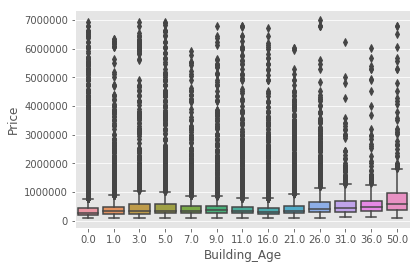

In [70]:
sns.boxplot(x="Building_Age",y="Price",data=dfs);

Seems like Old Buildings tend to have higher prices. Let's check with a mean plot.

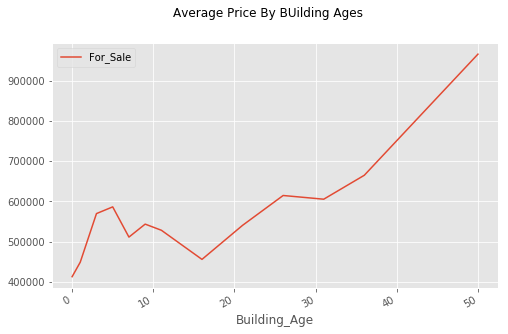

In [71]:

dfs.groupby(["Building_Age","Ad_Type"])["Price"].mean().unstack("Ad_Type")\
.plot(stacked=True,subplots=(2,1),title="Average Price By BUilding Ages",figsize=(8,5));

Old building seems to have higher price as we may see a an increase after 20. 

#### District vs Prices

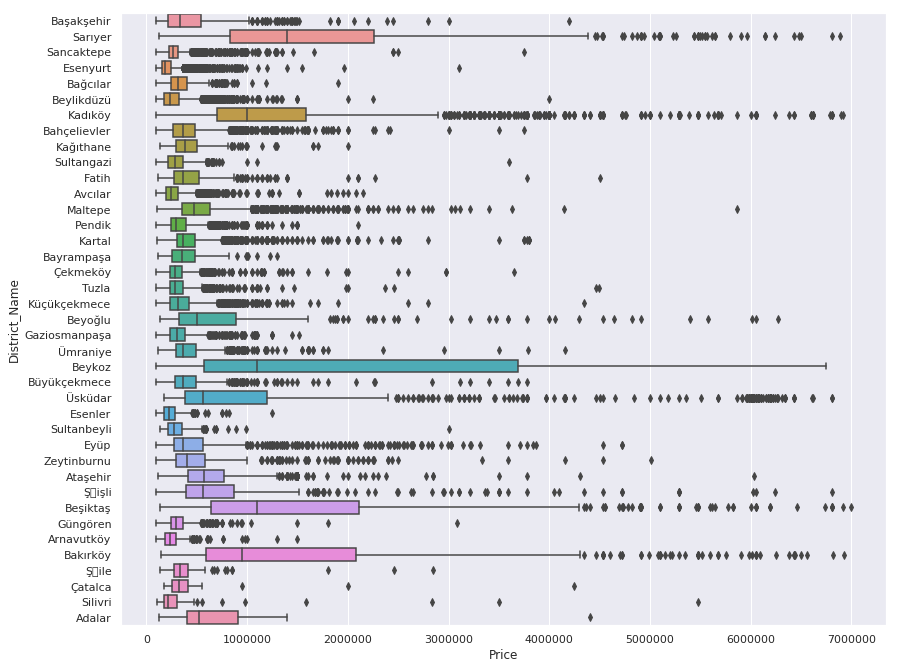

In [72]:
sns.set(rc={'figure.figsize':(13.7,11.27)})

sns.boxplot(y="District_Name", x="Price", data=dfs)


Sarıyer, Kadıköy,Beykoz, Beşiktas and Bakırköy are most expensive District in IStanbul

#### Room count vs prices

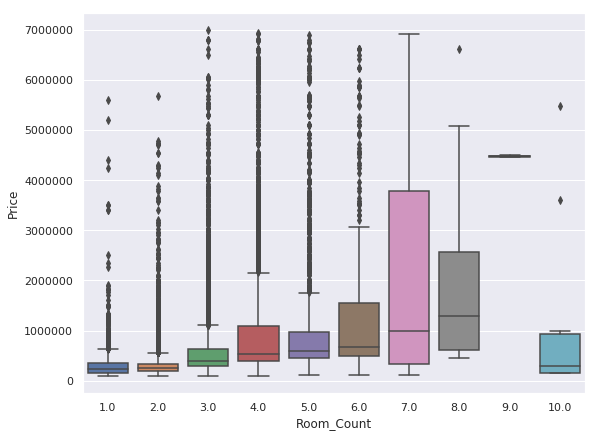

In [73]:
#I prepare seaborn using boxplots, it is just easier
sns.set(rc={'figure.figsize':(9,7)})
sns.boxplot(x="Room_Count",y="Price",data=dfs);


As expected Prices increase as room count increase; except 10 rooms properties. Lets check them

In [74]:
dfs[dfs["Room_Count"]==10][["District_Name","Square_Meter","Room_Count","Living_Room_Count","Price"]].sort_values("Price")

,District_Name,Square_Meter,Room_Count,Living_Room_Count,Price
11480,Ümraniye,45.00,10.00,2.00,"145,000.00"
11635,Beylikdüzü,85.00,10.00,2.00,"145,000.00"
11636,Beylikdüzü,85.00,10.00,2.00,"155,000.00"
69239,Beylikdüzü,90.00,10.00,2.00,"175,000.00"
8722,Beylikdüzü,105.00,10.00,2.00,"240,000.00"
71888,Beylikdüzü,125.00,10.00,2.00,"350,000.00"
60598,Şile,275.00,10.00,2.00,"700,000.00"
111972,Sultangazi,136.00,10.00,2.00,"1,000,000.00"
93954,Sultangazi,"1,300.00",10.00,2.00,"3,600,000.00"
65144,Silivri,520.00,10.00,2.00,"5,481,000.00"


The most of the 10 room entries seems wrong since their square meter are too low for 10 room apartments. We can eliminate them

In [75]:
dfs=dfs.loc[~((dfs["Room_Count"]==10)&(dfs["Square_Meter"]<250))]

#### Living Room vs prices

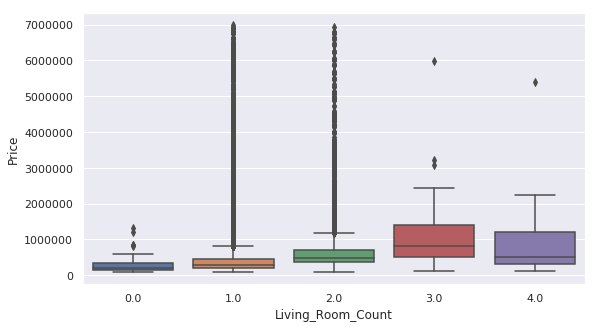

In [76]:
sns.set(rc={'figure.figsize':(9,5)})
sns.boxplot(x="Living_Room_Count",y="Price",data=dfs);


Everything as expected

#### Square Metter vs Prices

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


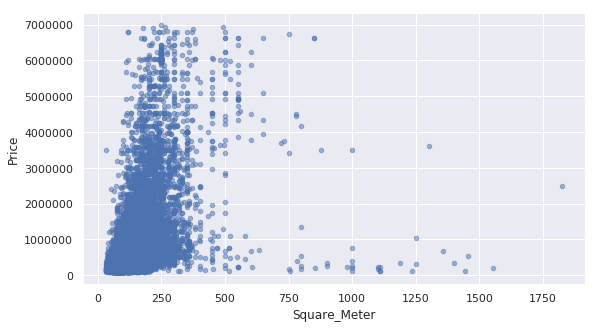

In [77]:
dfs.plot(kind="scatter",x="Square_Meter",y="Price",alpha=0.5);

We have some odd entries like 1000 square metter apartment for 110.000 TL. Let's check them

In [78]:
dfs.loc[(dfs["Square_Meter"]>750)&(dfs["Price"]<250000)][["District_Name","Square_Meter","Room_Count","Living_Room_Count","Price"]].sort_values("Price")

,District_Name,Square_Meter,Room_Count,Living_Room_Count,Price
96081,Ataşehir,"1,111.00",6.00,2.00,"111,111.00"
31283,Avcılar,"1,111.00",5.00,4.00,"111,122.00"
62409,Esenyurt,"1,000.00",2.00,1.00,"120,000.00"
4499,Adalar,"1,236.00",2.00,1.00,"123,588.00"
44118,Esenyurt,755.00,1.00,1.00,"125,000.00"
52211,Arnavutköy,"1,442.00",1.00,1.00,"133,444.00"
5596,Esenyurt,800.00,2.00,1.00,"185,000.00"
44405,Avcılar,"1,100.00",2.00,1.00,"190,000.00"
34486,Tuzla,"1,000.00",2.00,1.00,"198,000.00"
30648,Sultangazi,852.00,2.00,1.00,"205,000.00"


We can eliminate appartments with high Square Meters and low prices

In [79]:
dfs=dfs.loc[~((dfs["Square_Meter"]>750)&(dfs["Price"]<200000))]

#### Building Floor Count vs Prices

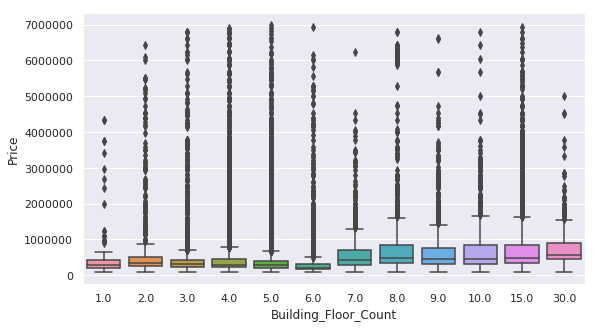

In [80]:
sns.set(rc={'figure.figsize':(9,5)})
sns.boxplot(x="Building_Floor_Count",y="Price",data=dfs);

#### Property Floor vs Prices

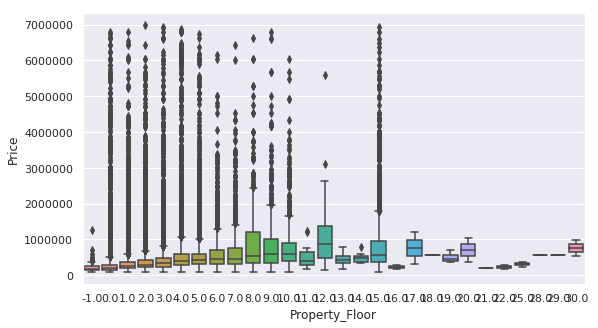

In [81]:
sns.set(rc={'figure.figsize':(9,5)})
sns.boxplot(x="Property_Floor",y="Price",data=dfs);

#### Bathroom Count vs Prices

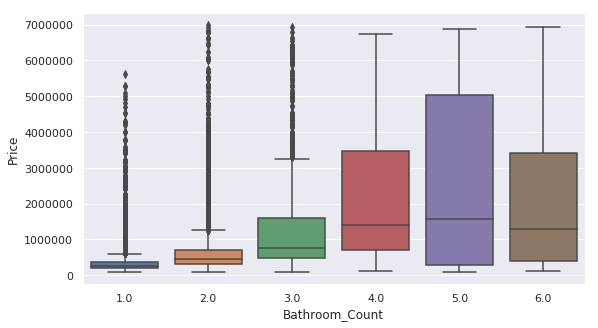

In [82]:
sns.set(rc={'figure.figsize':(9,5)})
sns.boxplot(x="Bathroom_Count",y="Price",data=dfs);

### Adding New Features


#### Floor Rate

Buildings Floor Count / Property Floor,  proprety's height rate in the building

In [83]:
dfs["Floor_Rate"]=dfs.Property_Floor/dfs.Building_Floor_Count

#### Neighbourhood Median Price

We will add neighbourhood Median Price

In [84]:
nbh_med=dfs.groupby("Neighbourhood_Code")["Price"].median()
nbh_med=pd.DataFrame({'Neighbourhood_Code':nbh_med.index, 'Neighbourhood_Median':nbh_med.values})
nbh_med.head()
dfs=dfs.merge(nbh_med,how="left",on="Neighbourhood_Code")

### Checking Correlations

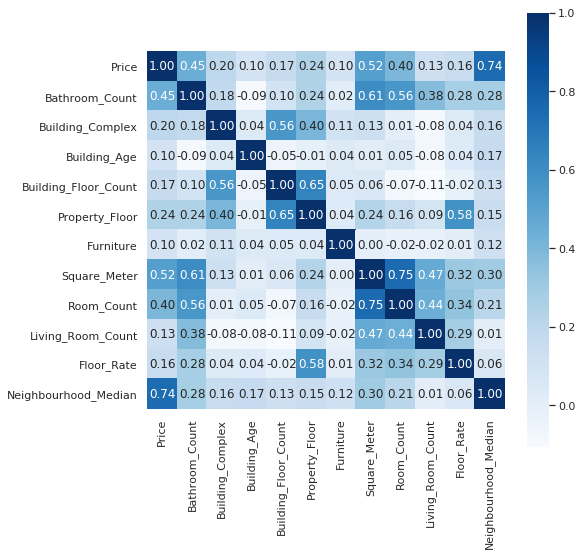

In [85]:
corr = dfs.drop(['Ad_Date', 'City_Code', 'City_Name', 'District_Code', 'District_Name',\
                 'Neighbourhood_Code', 'Neighbourhood_Name', 'Longitude', 'Lattitude',\
                'Ad_Type', 'Property_Type'],axis=1).corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 12},
           
           cmap= 'Blues');
plt.yticks(rotation=0);
plt.xticks(rotation=90);

We have some high correlation between some variables (Room Count Vs Square Meter) but no high multicollinearity detected.

## Predictions

### Linear Regression

Preparing Dataset for Linear Regression. We will use Neighbourhood_Name and drop District and City

- Converting Categorical Variables to Dummy Variables (Then dropping categorical columns)
- Changing Missing values with medians

In [86]:


#Dropping unnecessary columns

dflr=dfs.drop(['Ad_Date', 'City_Code', 'City_Name', 'District_Code', 'District_Name',
       'Neighbourhood_Code','Longitude', 'Lattitude',
        'Ad_Type', 'Property_Type']
,axis=1)


#Changing categorical columns with Dummy Variables.

categorical_columns=["Neighbourhood_Name","Building_Complex","Heating_Type","Furniture"]

for i in categorical_columns:
    dummy = pd.get_dummies(dflr[i],prefix=i)
    dflr = dflr.join(dummy)
    dflr = dflr.drop(i, axis=1)




mis=dflr.columns[dflr.isnull().any()]


from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='median', axis=1)

for i in mis:
    dflr[i] = imp.fit_transform(dflr[i].values.reshape(1,-1)).transpose()

y= dflr['Price']
dflr.drop("Price",inplace=True,axis=1)




/home/do/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [87]:
#importing train test split, metrics and sklearn Linear Regression libraries
from sklearn.model_selection import train_test_split
df_train, df_test, y_train, y_test = train_test_split(dflr, y , test_size = 0.30, random_state = 0)

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression



#Fitting default model
linreg = LinearRegression()
linreg.fit(df_train, y_train)





y_pred = linreg.predict(df_test) #y-hat values

#checking r2 score

from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.6996354547370822

Grid search to find best parameters

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]
            , "n_jobs":[-1]}
grid = GridSearchCV(model,parameters, cv=5)
grid.fit(df_train, y_train)

print("Best parameters set found on development set:")
print()
print(grid.best_params_," with ", grid.best_score_) #burada en üstte en iyiyi scorela beraber bassın dıye


Best parameters set found on development set:

{'copy_X': True, 'fit_intercept': False, 'n_jobs': -1, 'normalize': True}  with  0.7012024658151929


Remodeling with best parameters

In [89]:
linreg = LinearRegression(normalize=True,n_jobs=-1,fit_intercept= False)
linreg.fit(df_train, y_train)
y_pred = linreg.predict(df_test)
r2_score(y_test,y_pred)

0.6996320007180852

(10000, 1500000)

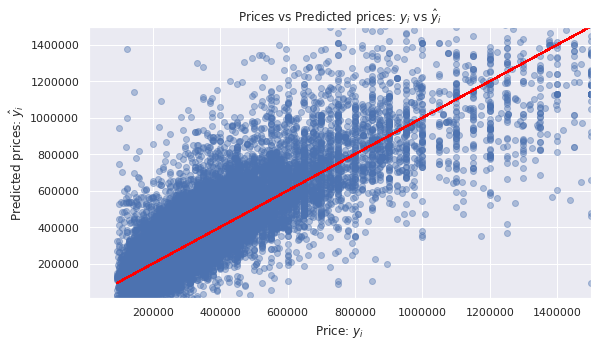

In [90]:
y_pred = linreg.predict(df_test) #y-hat values
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot(y_test, y_test, color='red',)
plt.xlabel("Price: $y_i$")
plt.ylabel("Predicted prices: $\hat{y}_i$")
plt.title("Prices vs Predicted prices: $y_i$ vs $\hat{y}_i$")
plt.xlim(xmax=1500000,xmin=10000)
plt.ylim(ymax=1500000,ymin=10000)

We have ~0.70 R2 score,not very bad. Let's check if we can optimize this.

Let's plot residuals:

Text(0.5, 1.0, 'Residual Plots')

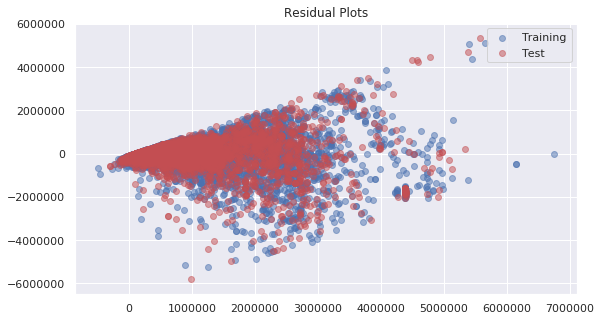

In [91]:
pred_train = linreg.predict(df_train) #Predictions for the training set
pred_test  = linreg.predict(df_test)  #Predictions for the test set
train_res  = plt.scatter(pred_train, (pred_train-y_train), c='b', alpha=0.5)
test_res   = plt.scatter(pred_test, (pred_test-y_test), c='r', alpha=0.5)
plt.legend((train_res, test_res),('Training','Test'),loc='upper right')
plt.title('Residual Plots')

We have heteroscedasticity (unequal variances). Let's check for normality of residuals. 

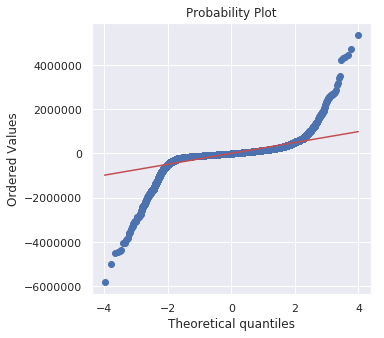

In [92]:
import scipy.stats as stats
residuals = y_pred-y_test #let's try residuals for the test dataset
plt.figure(figsize=(5,5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.show()

Our residuals have a non-normal distribution. (should be a strait line). We will try to fix the problem.

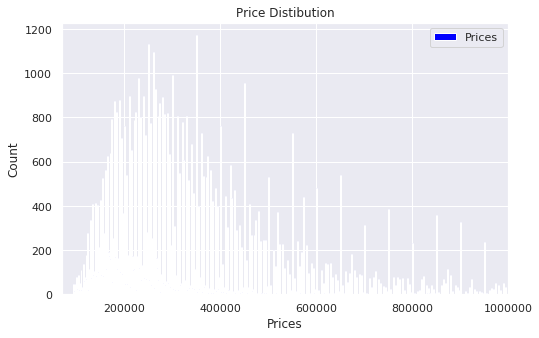

In [93]:

plt.figure(figsize=(8,5))
plt.hist(y, bins=4000, color='blue', label='Prices')
plt.title('Price Distibution')
plt.xlabel('Prices') ; plt.ylabel('Count') ; plt.legend(loc='upper right');

plt.xlim(xmax=1000000,xmin=70000)  # adjust the max leaving min unchanged
plt.show()

From the histogram for Price that we plotted in the beginning (EDA section), we see that the histogram is a bit right-skewwed. A log transformation of the target may fix that. Let's see:

In [94]:
ylog = np.log1p(y)

In [95]:
df_trainlog, df_testlog, y_trainlog, y_testlog = train_test_split(dflr, ylog, test_size = 0.30, random_state = 0)

In [96]:

linreg = LinearRegression(normalize=False,n_jobs=-1,fit_intercept= True)
linreg.fit(df_trainlog, y_trainlog)





y_predlog = linreg.predict(df_testlog) #y-hat values


from sklearn.metrics import r2_score
r2_score(y_testlog,y_predlog)

0.8034006492365696

We get a good boost on r2 square values after log target variable. Let's make a random test

In [97]:
np.expm1(linreg.predict(df_test.loc[5646].values.reshape(1, -1)))

array([253928.54274458])

In [98]:
y_test.loc[5646]

265000.0

253928 TL vs 265000.16 TL prediction, pretty good

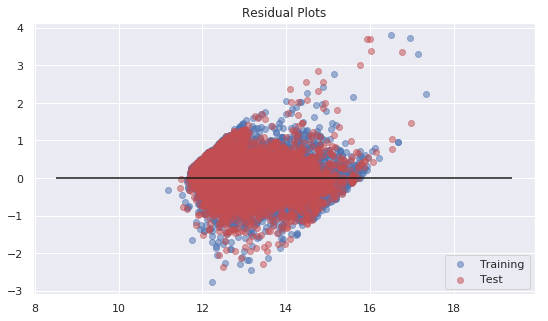

In [99]:

pred_train = linreg.predict(df_trainlog) #Predictions for the training set
pred_test  = linreg.predict(df_testlog)  #Predictions for the test set


train_res  = plt.scatter(pred_train, (pred_train-y_trainlog), c='b', alpha=0.5)
test_res   = plt.scatter(pred_test, (pred_test-y_testlog), c='r', alpha=0.5)
plt.hlines(y=0,xmin=8.5,xmax=19.4)
plt.legend((train_res, test_res),('Training','Test'),loc='lower right')
plt.title('Residual Plots')
plt.show()

Residuals are better now. We can complete Linear Regression part

### Light GBM

#### GBM

In [100]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import lightgbm as lgb


In [101]:
dfs.columns

Index(['Ad_Date', 'City_Code', 'City_Name', 'District_Code', 'District_Name',
       'Neighbourhood_Code', 'Neighbourhood_Name', 'Longitude', 'Lattitude',
       'Price', 'Ad_Type', 'Property_Type', 'Bathroom_Count',
       'Building_Complex', 'Building_Age', 'Building_Floor_Count',
       'Property_Floor', 'Heating_Type', 'Furniture', 'Square_Meter',
       'Room_Count', 'Living_Room_Count', 'Floor_Rate',
       'Neighbourhood_Median'],
      dtype='object')

In [102]:
dflgb=dfs.drop(['Ad_Date', 'City_Code', 'City_Name', 'District_Code', 'District_Name',
       'Neighbourhood_Code','Longitude', 'Lattitude','Ad_Type', 'Property_Type']
            ,axis=1)

In [103]:
dflgb["Heating_Type"].fillna("unknown",inplace=True)

In [104]:
dflgb["Furniture"].fillna("unknown",inplace=True)

Adjusting Categorical Variables

In [105]:
dflgb["Neighbourhood_Name"]=dflgb["Neighbourhood_Name"].astype("str")
dflgb["Furniture"]=dflgb["Furniture"].astype("str")

In [106]:
from sklearn.preprocessing import LabelEncoder

categorical_features = ['Neighbourhood_Name', 'Furniture',"Heating_Type"]

for i in categorical_features:
    le = LabelEncoder()
    dflgb[i] = le.fit_transform(dflgb[i])
print(dflgb.head())

   Neighbourhood_Name                Price       Bathroom_Count  \
0                 286           155,000.00                 1.00   
1                 337           466,000.00                 1.00   
2                 337           466,000.00                 1.00   
3                 183           350,000.00                 1.00   
4                 609           155,000.00                 1.00   

      Building_Complex         Building_Age  Building_Floor_Count  \
0                 1.00                 3.00                  8.00   
1                  nan                 0.00                  3.00   
2                  nan                 0.00                  3.00   
3                 1.00                 0.00                 15.00   
4                 0.00                 0.00                  6.00   

        Property_Floor  Heating_Type  Furniture         Square_Meter  \
0                 8.00            17          0                68.00   
1                 1.00             8  

In [107]:
y= dflgb['Price']


In [108]:
dflgb.drop("Price",inplace=True,axis=1)

train test split

In [109]:
df_train, df_test, y_train, y_test = train_test_split(dflgb, y, train_size = 0.75, test_size = 0.25, random_state = 0)

In [110]:
lgb_train = lgb.Dataset(data=df_train, label=y_train,  free_raw_data=False)

Parameters

In [111]:
params = {
    'task': 'predict',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'auc',
    'num_leaves': 300,
    'learning_rate': 0.2,
    'seed': 0
}


Categorical columns

In [112]:
categorical_indices = [0,2,6,7]

We applied cross validation to test best parameters

In [113]:
N_FOLDS = 5
MAX_BOOST_ROUNDS = 50
LEARNING_RATE = .0022
evals_result={}
cv_results = lgb.cv(params, lgb_train, num_boost_round=MAX_BOOST_ROUNDS, nfold=N_FOLDS, 
                    verbose_eval=20, early_stopping_rounds=40,stratified=False)




[20]	cv_agg's auc: 1 + 0
[40]	cv_agg's auc: 1 + 0


Best parameters found

In [114]:

gbm = lgb.train(params,
                lgb_train,
                num_boost_round = 50,
                categorical_feature = categorical_indices)

Current parameters:
 {'task': 'predict', 'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'auc', 'num_leaves': 300, 'learning_rate': 0.2, 'seed': 0, 'verbose': 1, 'categorical_column': [0, 2, 6, 7]}


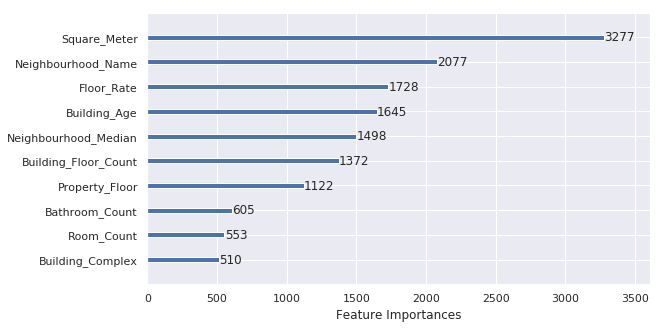

In [115]:
print('Current parameters:\n', params)
ax = lgb.plot_importance(gbm, max_num_features=10)
ax.set_title('')
ax.set_xlabel('Feature Importances')
ax.set_ylabel('')
plt.show()

In [116]:
y_pred = gbm.predict(df_test)

In [117]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.8249944528332054

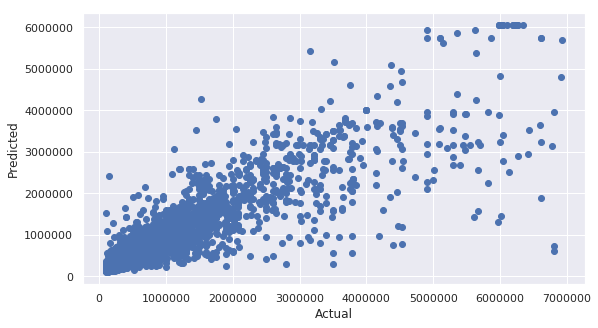

In [118]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

We will try to dummyfy all variable, and see if this can help trees with splitings

In [119]:
dflgb1=dflgb.copy()
categorical_columns=['Neighbourhood_Name', 'Bathroom_Count', 'Building_Complex',
       'Building_Age', 'Building_Floor_Count', 'Property_Floor',
       'Heating_Type', 'Furniture', 'Square_Meter', 'Room_Count',
       'Living_Room_Count', 'Floor_Rate', 'Neighbourhood_Median']

for i in categorical_columns:
    dummy = pd.get_dummies(dflgb[i],prefix=i)
    dflgb1 = dflgb1.join(dummy)
    dflg1b = dflgb1.drop(i, axis=1)


In [120]:



df_train1, df_test1, y_train1, y_test1 = train_test_split(dflgb1, y, train_size = 0.75, test_size = 0.25, random_state = 0)
lgb_train1 = lgb.Dataset(data=df_train1, label=y_train1,  free_raw_data=False)

gbm1 = lgb.train(params,
                lgb_train1,
               )

y_pred1 = gbm1.predict(df_test1)

from sklearn.metrics import r2_score
r2_score(y_test1,y_pred1)

0.8333194666885047

Current parameters:
 {'task': 'predict', 'boosting_type': 'gbdt', 'objective': 'regression_l1', 'metric': 'auc', 'num_leaves': 300, 'learning_rate': 0.2, 'seed': 0, 'verbose': 1, 'categorical_column': [0, 2, 6, 7]}


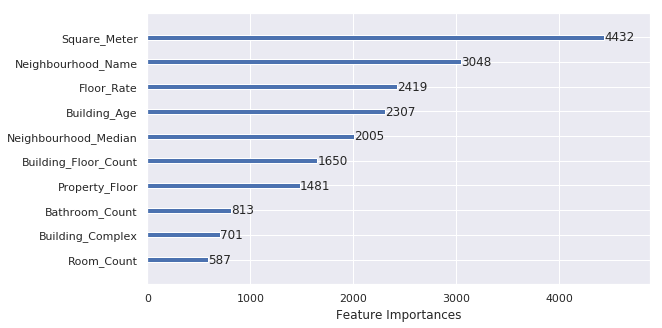

In [121]:
print('Current parameters:\n', params)
ax = lgb.plot_importance(gbm1, max_num_features=10)
ax.set_title('')
ax.set_xlabel('Feature Importances')
ax.set_ylabel('')
plt.show()

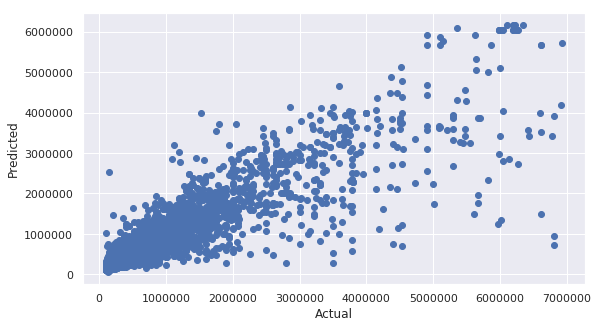

In [122]:
plt.scatter(y_test1, y_pred1)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

We get slightly better results with on LightGBM with all variable dummyfications.